In [1]:
import pandas as pd
import numpy as np
#from plotnine import *
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import cohen_kappa_score
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.svm import SVC

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import log_loss
from sklearn.pipeline import Pipeline
from sklearn.ensemble import VotingClassifier 
from sklearn.ensemble import BaggingClassifier 

from scipy.interpolate import interp1d
from scipy import interpolate
    
import statsmodels.api as sm
import itertools

from scipy.stats import mode

import random
 
import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline
import seaborn as sns
sns.set()

import xgboost as xgb

C:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
train = pd.read_csv('C:\\Users\\i053131\\Desktop\\Epilepsie\\CFM\\data\\raw\\training_input.csv', sep=';')
test = pd.read_csv('C:\\Users\\i053131\\Desktop\\Epilepsie\\CFM\\data\\raw\\testing_input.csv', sep=';') 
output = pd.read_csv('C:\\Users\\i053131\\Desktop\\Epilepsie\\CFM\\data\\raw\\challenge_output_data_training_file_volatility_prediction_in_financial_markets.csv', sep=';')

In [3]:
y = output["TARGET"]

In [4]:
df = train.copy()

In [5]:
df.head()

,ID,date,product_id,volatility 09:30:00,volatility 09:35:00,volatility 09:40:00,volatility 09:45:00,volatility 09:50:00,volatility 09:55:00,volatility 10:00:00,...,return 13:10:00,return 13:15:00,return 13:20:00,return 13:25:00,return 13:30:00,return 13:35:00,return 13:40:00,return 13:45:00,return 13:50:00,return 13:55:00
0,1,1,1,0.662737,0.716896,0.698601,0.480172,0.623665,0.201876,0.327206,...,1.0,1.0,1.0,-1.0,1.0,-1.0,0.0,1.0,1.0,-1.0
1,2,1,2,0.285394,0.379560,0.094858,0.094794,0.055315,0.173994,0.102745,...,1.0,1.0,1.0,1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0
2,3,1,3,1.151646,1.093562,1.833443,0.595823,0.310177,0.792310,0.401979,...,1.0,1.0,-1.0,-1.0,1.0,1.0,-1.0,1.0,1.0,1.0
3,4,1,4,0.835260,0.329615,0.340366,0.216692,0.350371,0.247594,0.341194,...,-1.0,1.0,1.0,0.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0
4,5,1,5,0.274185,0.061076,0.010168,0.060890,0.000000,0.213162,0.162763,...,-1.0,1.0,1.0,0.0,1.0,0.0,-1.0,-1.0,-1.0,0.0


In [6]:
return_ = train.iloc[:, 57:]
returnTest = test.iloc[:, 57:]

In [7]:
return_.head()

,return 09:30:00,return 09:35:00,return 09:40:00,return 09:45:00,return 09:50:00,return 09:55:00,return 10:00:00,return 10:05:00,return 10:10:00,return 10:15:00,...,return 13:10:00,return 13:15:00,return 13:20:00,return 13:25:00,return 13:30:00,return 13:35:00,return 13:40:00,return 13:45:00,return 13:50:00,return 13:55:00
0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,1.0,1.0,-1.0,-1.0,...,1.0,1.0,1.0,-1.0,1.0,-1.0,0.0,1.0,1.0,-1.0
1,1.0,1.0,1.0,0.0,-1.0,-1.0,1.0,-1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0
2,-1.0,-1.0,1.0,1.0,1.0,-1.0,1.0,1.0,1.0,-1.0,...,1.0,1.0,-1.0,-1.0,1.0,1.0,-1.0,1.0,1.0,1.0
3,-1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,1.0,-1.0,...,-1.0,1.0,1.0,0.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0
4,1.0,-1.0,0.0,1.0,0.0,-1.0,-1.0,-1.0,1.0,1.0,...,-1.0,1.0,1.0,0.0,1.0,0.0,-1.0,-1.0,-1.0,0.0


In [8]:
volatility = train.iloc[:,3:57]
volatilityTest=test.iloc[:,3:57]
volatility.head()

,volatility 09:30:00,volatility 09:35:00,volatility 09:40:00,volatility 09:45:00,volatility 09:50:00,volatility 09:55:00,volatility 10:00:00,volatility 10:05:00,volatility 10:10:00,volatility 10:15:00,...,volatility 13:10:00,volatility 13:15:00,volatility 13:20:00,volatility 13:25:00,volatility 13:30:00,volatility 13:35:00,volatility 13:40:00,volatility 13:45:00,volatility 13:50:00,volatility 13:55:00
0,0.662737,0.716896,0.698601,0.480172,0.623665,0.201876,0.327206,0.374239,0.207611,0.213038,...,0.115572,0.230885,0.062962,0.274345,0.393201,0.078658,0.041951,0.115287,0.136218,0.052386
1,0.285394,0.379560,0.094858,0.094794,0.055315,0.173994,0.102745,0.079102,0.047445,0.071119,...,0.031630,0.079048,0.071119,0.078995,0.220849,0.142118,0.039484,0.055287,0.059276,0.071155
2,1.151646,1.093562,1.833443,0.595823,0.310177,0.792310,0.401979,0.336490,0.619155,0.504735,...,0.118179,0.275287,0.249349,0.262916,0.341119,0.170464,0.275906,0.196799,0.111488,0.117980
3,0.835260,0.329615,0.340366,0.216692,0.350371,0.247594,0.341194,0.175573,0.278420,0.113430,...,0.041458,0.217509,0.103530,0.031052,0.217124,0.186312,0.051811,0.093239,0.082934,0.155294
4,0.274185,0.061076,0.010168,0.060890,0.000000,0.213162,0.162763,0.203675,0.456380,0.303923,...,0.071567,0.275442,0.081595,0.020390,0.162940,0.040744,0.122338,0.050963,0.112193,0.000000


In [9]:
# double passe sur la serie - reecrire
def count_NA(s):
    result = 0
    if s.isna().any():
        result = s.value_counts(dropna=False).loc[np.nan]
        
    return result

def count_ones(s):
    result = 0
    if (1 in s.unique()):
        result = s.value_counts().loc[1]
    return result

def count_zeros(s):
    result = 0
    if (0 in s.unique()):
        result = s.value_counts().loc[0]
    return result

def count_minus(s):
    result = 0
    if (-1 in s.unique()):
        result = s.value_counts().loc[-1]
    return result



In [10]:
return_sum = return_.sum(axis=1)

Text(0,0.5,'#')

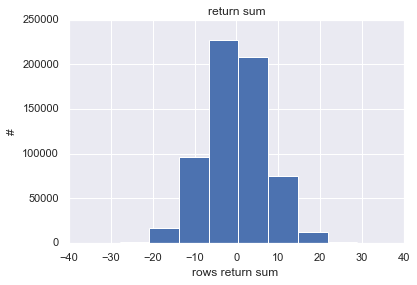

In [11]:
plt.hist(return_sum)
plt.title("return sum")
plt.xlabel("rows return sum ")
plt.ylabel("#")
#plt.yscale('log', nonposy='clip')

In [12]:
return_abssum = np.abs(return_).sum(axis=1)

Text(0,0.5,'#')

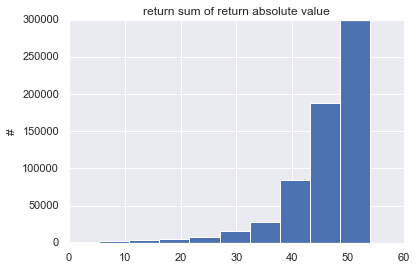

In [13]:
plt.hist(return_abssum)
plt.title("return sum of return absolute value")
#plt.xlabel("rows return sum ")
plt.ylabel("#")
#plt.yscale('log', nonposy='clip')

In [14]:
train.iloc[:,1:57].columns

Index(['date', 'product_id', 'volatility 09:30:00', 'volatility 09:35:00',
       'volatility 09:40:00', 'volatility 09:45:00', 'volatility 09:50:00',
       'volatility 09:55:00', 'volatility 10:00:00', 'volatility 10:05:00',
       'volatility 10:10:00', 'volatility 10:15:00', 'volatility 10:20:00',
       'volatility 10:25:00', 'volatility 10:30:00', 'volatility 10:35:00',
       'volatility 10:40:00', 'volatility 10:45:00', 'volatility 10:50:00',
       'volatility 10:55:00', 'volatility 11:00:00', 'volatility 11:05:00',
       'volatility 11:10:00', 'volatility 11:15:00', 'volatility 11:20:00',
       'volatility 11:25:00', 'volatility 11:30:00', 'volatility 11:35:00',
       'volatility 11:40:00', 'volatility 11:45:00', 'volatility 11:50:00',
       'volatility 11:55:00', 'volatility 12:00:00', 'volatility 12:05:00',
       'volatility 12:10:00', 'volatility 12:15:00', 'volatility 12:20:00',
       'volatility 12:25:00', 'volatility 12:30:00', 'volatility 12:35:00',
       'volat

In [15]:
#add to ids and volatility 
#  % of NA in volatility
#  % of 1, 0, -1 in return 
# sum and sum of absolute values of return 

def build_features_1(df):
    return_ = df.iloc[:, 57:]
    volatility = df.iloc[:,3:57]
    result= df.iloc[:,:57].copy()
    #feature NA count
    lna=[]
    lones=[]
    lzeros =[]
    lminus =[]
    for i in df.index:
        v = count_NA(volatility.iloc[i, :])/volatility.shape[1]
        lna.append(v)
        lones.append(count_ones(return_.iloc[i, :])/return_.shape[1])
        lzeros.append(count_zeros(return_.iloc[i, :])/return_.shape[1])
        lminus.append(count_minus(return_.iloc[i, :])/return_.shape[1])
        if (i % (round(volatility.shape[0]/10)) ==0):
            print(i, "tenth of first part completed")
    
    result["NA"]=pd.Series(lna)
    result["return_ones"] = pd.Series(lones)
    result["return_zeros"] = pd.Series(lzeros)
    result["return_minusones"] = pd.Series(lminus)
    
    # features return sum and sum of the absolute values 
    result["return_sum"]=  return_.sum(axis=1)
    result["return_abssum"] = np.abs(return_).sum(axis=1)

    return result
    

In [16]:
fdf = build_features_1(df)

0 tenth of first part completed
63631 tenth of first part completed
127262 tenth of first part completed
190893 tenth of first part completed
254524 tenth of first part completed
318155 tenth of first part completed
381786 tenth of first part completed
445417 tenth of first part completed
509048 tenth of first part completed
572679 tenth of first part completed
636310 tenth of first part completed


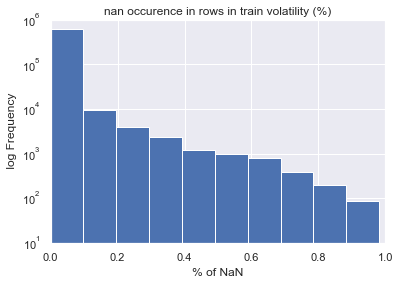

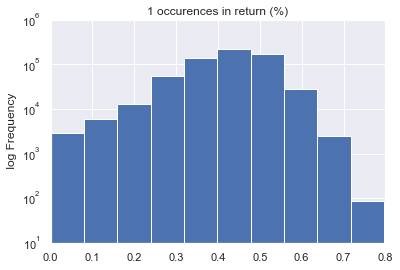

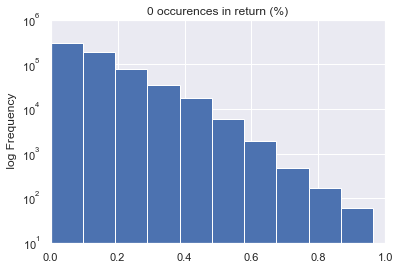

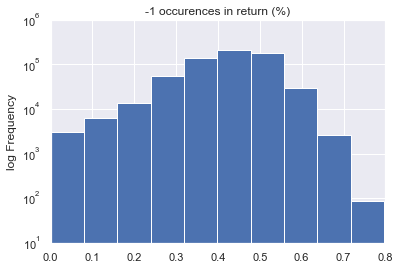

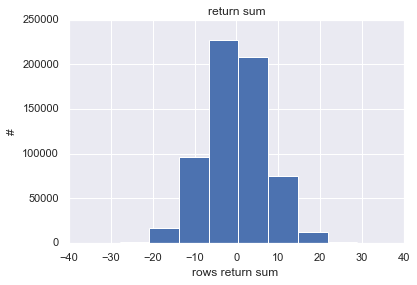

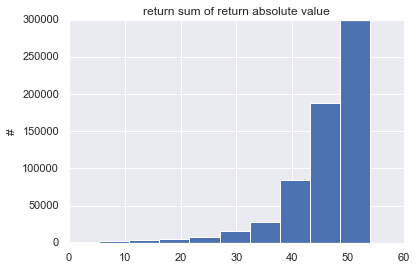

In [17]:
plt.hist(fdf["NA"])
plt.title("nan occurence in rows in train volatility (%)")
plt.xlabel("% of NaN")
plt.ylabel(" log Frequency")
plt.yscale('log', nonposy='clip')
plt.show()

plt.hist(fdf["return_ones"])
plt.title("1 occurences in return (%)")
plt.ylabel(" log Frequency")
plt.yscale('log', nonposy='clip')
plt.show()

plt.hist(fdf["return_zeros"])
plt.title("0 occurences in return (%)")
plt.ylabel(" log Frequency")
plt.yscale('log', nonposy='clip')
plt.show()

plt.hist(fdf["return_minusones"])
plt.title("-1 occurences in return (%)")
plt.ylabel("log Frequency")
plt.yscale('log', nonposy='clip')
plt.show()


plt.hist(fdf["return_sum"])
plt.title("return sum")
plt.xlabel("rows return sum ")
plt.ylabel("#")
plt.show()

plt.hist(fdf["return_abssum"])
plt.title("return sum of return absolute value")
#plt.xlabel("rows return sum ")
plt.ylabel("#")
#plt.yscale('log', nonposy='clip')
plt.show()


#### trying  straighforward xgboost on volatility + new features (build_features_1)

In [18]:
fdf.columns

Index(['ID', 'date', 'product_id', 'volatility 09:30:00',
       'volatility 09:35:00', 'volatility 09:40:00', 'volatility 09:45:00',
       'volatility 09:50:00', 'volatility 09:55:00', 'volatility 10:00:00',
       'volatility 10:05:00', 'volatility 10:10:00', 'volatility 10:15:00',
       'volatility 10:20:00', 'volatility 10:25:00', 'volatility 10:30:00',
       'volatility 10:35:00', 'volatility 10:40:00', 'volatility 10:45:00',
       'volatility 10:50:00', 'volatility 10:55:00', 'volatility 11:00:00',
       'volatility 11:05:00', 'volatility 11:10:00', 'volatility 11:15:00',
       'volatility 11:20:00', 'volatility 11:25:00', 'volatility 11:30:00',
       'volatility 11:35:00', 'volatility 11:40:00', 'volatility 11:45:00',
       'volatility 11:50:00', 'volatility 11:55:00', 'volatility 12:00:00',
       'volatility 12:05:00', 'volatility 12:10:00', 'volatility 12:15:00',
       'volatility 12:20:00', 'volatility 12:25:00', 'volatility 12:30:00',
       'volatility 12:35:00', 

In [19]:
#training, valid  = train_test_split(pd.concat([fdf, output["TARGET"]], axis=1), test_size=0.2, random_state=42, stratify=fdf.iloc[:,1:2])
#df= pd.concat([train, output["TARGET"]], axis=1)
#df=fdf
df= pd.concat([fdf, output["TARGET"]], axis=1)
valid = df[df.date>=1563]
training = df[df.date<1563]

In [20]:
X = training.iloc[:,1:56]
y = training.iloc[:,-1]

X_valid = valid.iloc[:,1:56]
y_true = valid.iloc[:,-1]
logy = np.log(y)



In [21]:
def MAPE(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
def MAPE_residus(y_true, y_pred):
    return np.abs((y_true - y_pred) / y_true)

In [22]:
%%time
Lm = []
Lt= []
Ld = []
r = range(50, 210, 10)
for i in r:    
    xbr= xgb.XGBRegressor(max_depth=3, learning_rate=0.1, n_estimators=i,  subsample=1,  
                       random_state=42, n_jobs=-1)
    xbr.fit(X, logy)

    logy_pred = xbr.predict(X_valid)
    y_pred = np.exp(logy_pred )
    m= MAPE(y_true, y_pred)
    logyt = xbr.predict(X)
    yt = np.exp(logyt)
    t= MAPE(y, yt)                
    print("mape valid:    "+ str(i), m)
    print("mape training: "+ str(i), t)
    print("delta", m-t)
    print("--------------")              
    
    Lm.append(m)
    Lt.append(t)
    Ld.append(m-t)

mape valid:    50 26.21492711358825
mape training: 50 26.38369066053492
delta -0.16876354694667128
--------------
mape valid:    60 26.351380453826263
mape training: 60 25.893508347718164
delta 0.45787210610809836
--------------
mape valid:    70 26.403752424637016
mape training: 70 25.657353492759917
delta 0.7463989318770992
--------------
mape valid:    80 26.61270385073472
mape training: 80 25.525200921083513
delta 1.0875029296512082
--------------
mape valid:    90 26.36877106406599
mape training: 90 25.42780166822113
delta 0.94096939584486
--------------
mape valid:    100 26.235757499596346
mape training: 100 25.353222887851768
delta 0.8825346117445783
--------------
mape valid:    110 26.19135048117479
mape training: 110 25.28396283965092
delta 0.9073876415238722
--------------
mape valid:    120 26.189075488619668
mape training: 120 25.226187013634295
delta 0.9628884749853732
--------------
mape valid:    130 26.23821143000947
mape training: 130 25.177711529810846
delta 1.06049

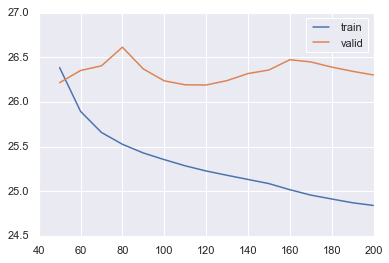

In [23]:

plt.plot(r, Lt, label = "train")
plt.plot(r, Lm, label = "valid")
plt.legend(loc='upper right')
plt.show()



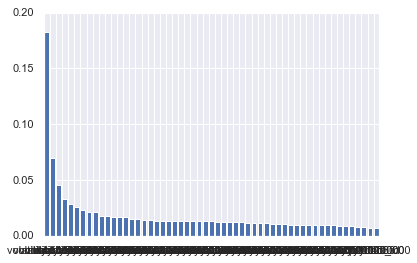

,importance
date,0.182143
volatility 13:50:00,0.070000
volatility 13:45:00,0.045714
volatility 13:35:00,0.032857
volatility 13:30:00,0.028571
volatility 13:40:00,0.025714
volatility 12:45:00,0.022857
volatility 13:25:00,0.021429
volatility 13:05:00,0.021429
volatility 09:30:00,0.017857


In [24]:
importances = xbr.feature_importances_
feature_importances = pd.DataFrame(importances, index = X.columns, 
                                   columns=['importance']).sort_values('importance', ascending=False)
plt.bar(feature_importances.index, feature_importances["importance"])
plt.show()

feature_importances

#### investidating depth
- more indices of overfitting more than anything else

In [25]:
%%time
Lm = []
Lt= []
Ld = []
r = range(3, 10)
for i in r:    
    xbr= xgb.XGBRegressor(max_depth=i, learning_rate=0.1, n_estimators=140,  subsample=1,  
                       random_state=42, n_jobs=-1)
    xbr.fit(X, logy)

    logy_pred = xbr.predict(X_valid)
    y_pred = np.exp(logy_pred )
    m= MAPE(y_true, y_pred)
    logyt = xbr.predict(X)
    yt = np.exp(logyt)
    t= MAPE(y, yt)                
    print("mape valid:    "+ str(i), m)
    print("mape training: "+ str(i), t)
    print("delta", m-t)
    print("--------------")              
    
    Lm.append(m)
    Lt.append(t)
    Ld.append(m-t)

mape valid:    3 26.31710034418024
mape training: 3 25.131333155830593
delta 1.1857671883496472
--------------
mape valid:    4 25.74663353968197
mape training: 4 24.577840881125187
delta 1.1687926585567823
--------------
mape valid:    5 25.852552428883236
mape training: 5 23.928005530237762
delta 1.924546898645474
--------------
mape valid:    6 25.725513778729432
mape training: 6 23.180871496549862
delta 2.54464228217957
--------------
mape valid:    7 25.591026445064518
mape training: 7 22.07880780715679
delta 3.512218637907729
--------------
mape valid:    8 25.829104791415393
mape training: 8 21.03261465525013
delta 4.796490136165264
--------------
mape valid:    9 25.579356576091648
mape training: 9 19.5575059337623
delta 6.021850642329348
--------------
Wall time: 23min 59s


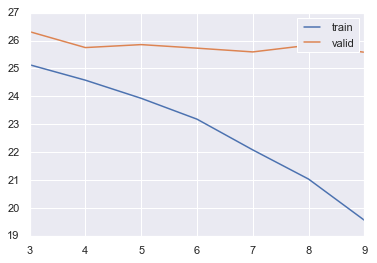

In [26]:

plt.plot(r, Lt, label = "train")
plt.plot(r, Lm, label = "valid")
plt.legend(loc='upper right')
plt.show()

#### with all but date

In [27]:
df= pd.concat([fdf, output["TARGET"]], axis=1)
valid = df[df.date>=1563]
training = df[df.date<1563]
X = training.iloc[:,1:-1]
y = training.iloc[:,-1]

X_valid = valid.iloc[:,1:-1]
y_true = valid.iloc[:,-1]
logy = np.log(y)

In [28]:
%%time
Lm = []
Lt= []
Ld = []
r = range(80, 170, 30)
for i in r:    
    xbr= xgb.XGBRegressor(max_depth=3, learning_rate=0.1, n_estimators=i,  subsample=1,  
                       random_state=42, n_jobs=-1)
    xbr.fit(X, logy)

    logy_pred = xbr.predict(X_valid)
    y_pred = np.exp(logy_pred )
    m= MAPE(y_true, y_pred)
    logyt = xbr.predict(X)
    yt = np.exp(logyt)
    t= MAPE(y, yt)                
    print("mape valid:    "+ str(i), m)
    print("mape training: "+ str(i), t)
    print("delta", m-t)
    print("--------------")              
    
    Lm.append(m)
    Lt.append(t)
    Ld.append(m-t)

mape valid:    80 25.63389072444393
mape training: 80 25.09743314017925
delta 0.5364575842646815
--------------
mape valid:    110 25.442227894703745
mape training: 110 24.820818155820092
delta 0.6214097388836528
--------------
mape valid:    140 25.57137407445919
mape training: 140 24.63807024450408
delta 0.9333038299551113
--------------
Wall time: 3min 55s


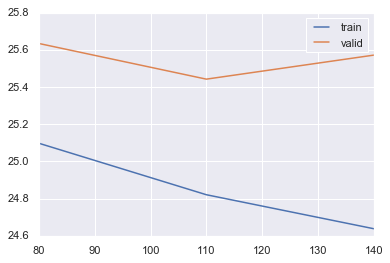

In [29]:

plt.plot(r, Lt, label = "train")
plt.plot(r, Lm, label = "valid")
plt.legend(loc='upper right')

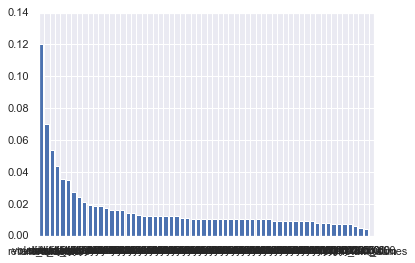

,importance
date,0.120408
return_abssum,0.070408
return_zeros,0.054082
volatility 13:55:00,0.043878
return_ones,0.035714
volatility 13:50:00,0.034694
volatility 13:45:00,0.027551
volatility 13:40:00,0.024490
volatility 13:35:00,0.021429
volatility 12:45:00,0.019388


In [30]:
importances = xbr.feature_importances_
feature_importances = pd.DataFrame(importances, index = X.columns, 
                                   columns=['importance']).sort_values('importance', ascending=False)
plt.bar(feature_importances.index, feature_importances["importance"])
plt.show()

feature_importances

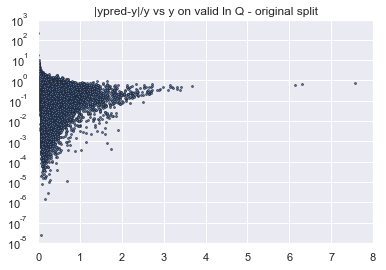

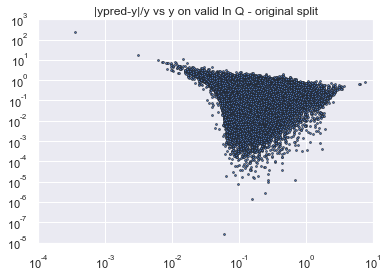

Text(0.5,1,'|ypred-y|/y vs y on train ln Q - original split')

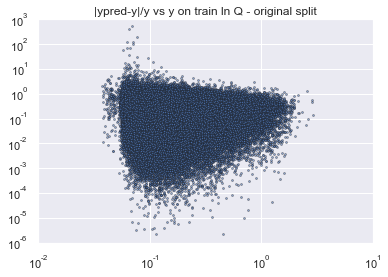

In [31]:
df= valid.copy()
df["ypred"]= y_pred
df["residus"]= MAPE_residus(df["TARGET"], df["ypred"])

dftrain= training.copy()
dftrain["yt"]= yt
dftrain["residus"]= MAPE_residus(dftrain["TARGET"], dftrain["yt"])



plt.plot( 'TARGET', 'residus', data=df, linestyle='', marker='o', markersize=2)
plt.yscale('log', nonposy='clip')
#ax.set_xlim(0,)
plt.title("|ypred-y|/y vs y on valid ln Q - original split")
plt.show()

ax = plt.subplot()
ax.set_xscale("log", nonposx='clip')
ax.set_yscale("log", nonposy='clip')
plt.plot( 'TARGET', 'residus', data=df, linestyle='', marker='o', markersize=2)
#ax.set_ylim(ymin=0.1)
ax.set_title('|ypred-y|/y vs y on valid ln Q - original split')
plt.show()

ax = plt.subplot()
ax.set_xscale("log", nonposx='clip')
ax.set_yscale("log", nonposy='clip')
plt.plot( 'yt', 'residus', data=dftrain, linestyle='', marker='o', markersize=2, alpha=0.6)
ax.set_title('|ypred-y|/y vs y on train ln Q - original split')

In [32]:
### target impact des NAN

In [33]:
tdf = fdf.copy()
tdf['TARGET'] = output["TARGET"]

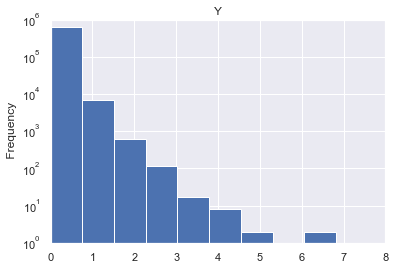

In [34]:
plt.hist(tdf["TARGET"])
plt.title("Y")
plt.ylabel(" Frequency")
plt.yscale('log', nonposy='clip')
plt.show()

In [35]:
tdf[tdf.NA < 0.1].shape
#tdf.shape

(617021, 64)

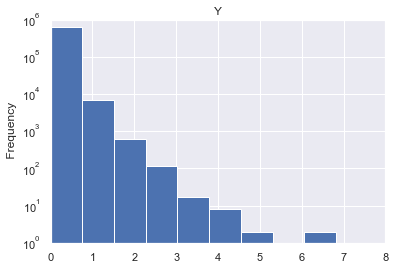

In [36]:
plt.hist(tdf["TARGET"])
plt.title("Y")
plt.ylabel(" Frequency")
plt.yscale('log', nonposy='clip')
plt.show()

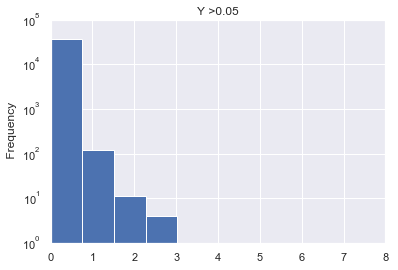

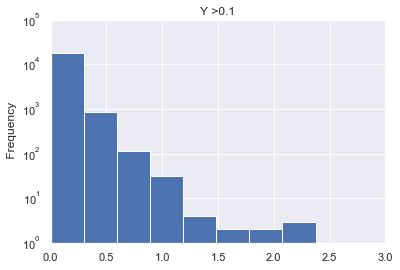

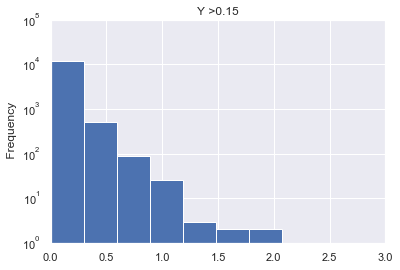

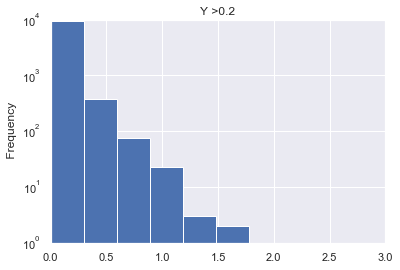

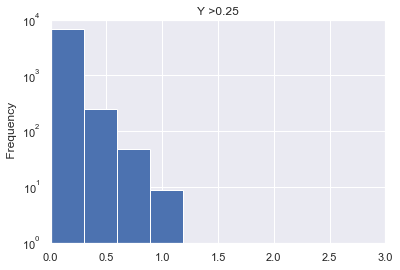

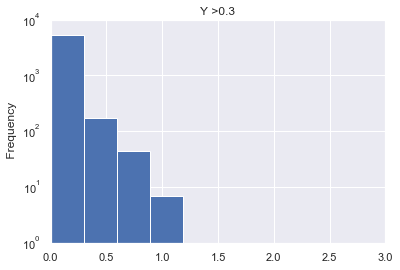

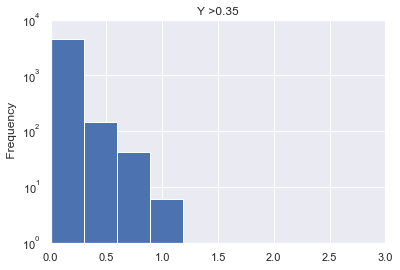

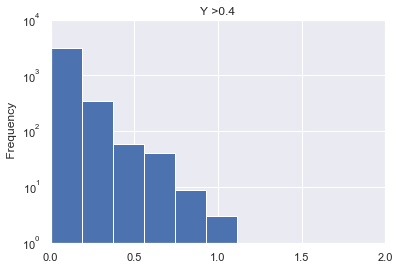

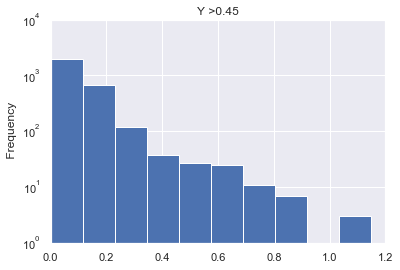

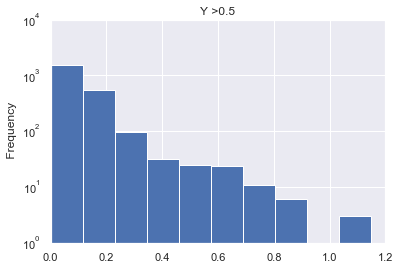

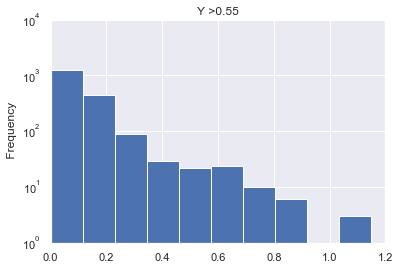

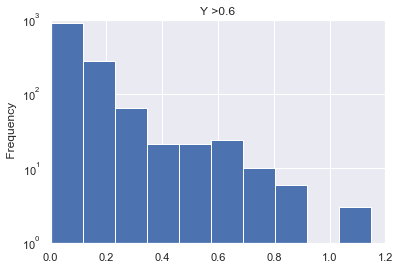

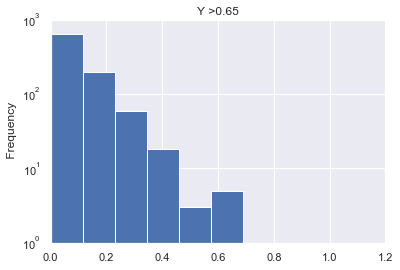

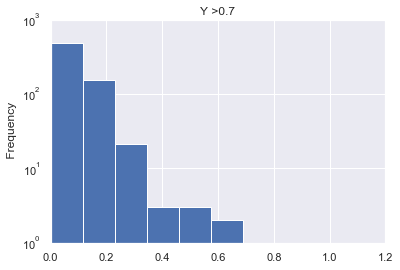

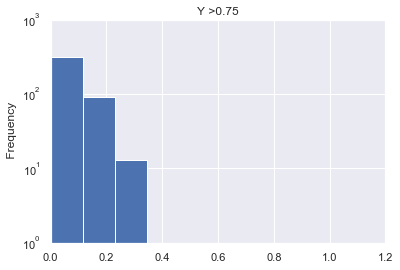

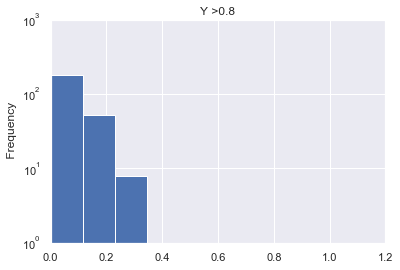

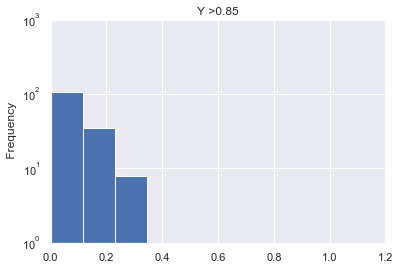

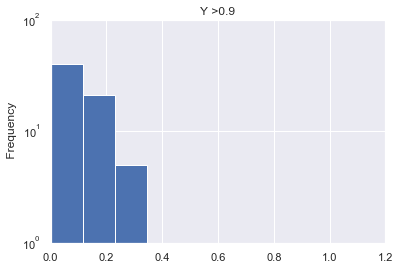

In [37]:

for i in range(1, 19):
    l =i/20
    plt.hist(tdf[tdf.NA > l]["TARGET"])
    plt.title("Y >"+ str(l))
    plt.ylabel(" Frequency")
    plt.yscale('log', nonposy='clip')
    plt.show()

(0, 8.0)

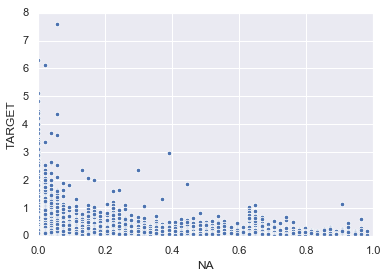

In [38]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

ax = sns.scatterplot(x=tdf["NA"], y=tdf["TARGET"], data=tdf)
ax.set_xlim(0,1)
ax.set_ylim(0,)

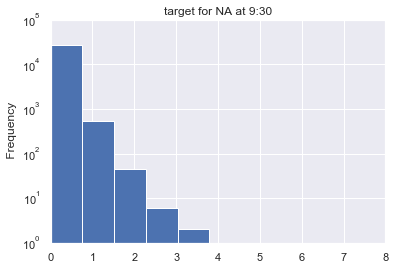

In [39]:

#tdf[tdf['volatility 09:30:00'].isna()]


plt.hist(tdf[tdf['volatility 09:30:00'].isna()]["TARGET"])
plt.title("target for NA at 9:30")
plt.ylabel(" Frequency")
plt.yscale('log', nonposy='clip')
plt.show()

##### investigating depth (all step 1 features nbut dates)
- pareil: indices d'overfitting

In [40]:
%%time
Lm = []
Lt= []
Ld = []
r = range(3, 7)
for i in r:    
    xbr= xgb.XGBRegressor(max_depth=i, learning_rate=0.1, n_estimators=140,  subsample=1,  
                       random_state=42, n_jobs=-1)
    xbr.fit(X, logy)

    logy_pred = xbr.predict(X_valid)
    y_pred = np.exp(logy_pred )
    m= MAPE(y_true, y_pred)
    logyt = xbr.predict(X)
    yt = np.exp(logyt)
    t= MAPE(y, yt)                
    print("mape valid:    "+ str(i), m)
    print("mape training: "+ str(i), t)
    print("delta", m-t)
    print("--------------")              
    
    Lm.append(m)
    Lt.append(t)
    Ld.append(m-t)

mape valid:    3 25.57137407445919
mape training: 3 24.63807024450408
delta 0.9333038299551113
--------------
mape valid:    4 25.23035795088015
mape training: 4 24.135829086627744
delta 1.094528864252407
--------------
mape valid:    5 25.17253731045132
mape training: 5 23.424523318038386
delta 1.748013992412936
--------------
mape valid:    6 25.09314689575209
mape training: 6 22.722664523700033
delta 2.370482372052056
--------------
Wall time: 10min 1s


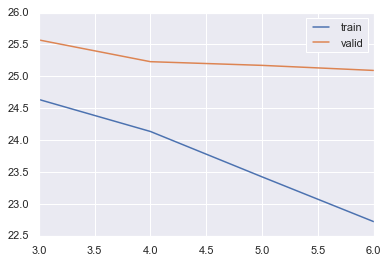

In [41]:
plt.plot(r, Lt, label = "train")
plt.plot(r, Lm, label = "valid")
plt.legend(loc='upper right')
plt.show()

# Adding mean, std,... for valatilities as features

In [42]:
temp= fdf.loc[:, 'volatility 09:30:00':'volatility 13:55:00']

temp.mean(axis=1)

0         0.257565
1         0.078033
2         0.356612
3         0.192071
4         0.105580
5         0.153761
6         0.200458
7         0.201893
8         0.136637
9         0.197429
10        0.135070
11        0.128164
12        0.203661
13        0.276832
14        0.124583
15        0.278302
16        0.129927
17        0.152222
18        0.146770
19        0.159946
20        0.082166
21        0.234897
22        0.453514
23        0.113714
24        0.150537
25        0.109125
26        0.270659
27        0.135687
28        0.084514
29        0.135251
            ...   
636283    0.096471
636284    0.193158
636285    0.213427
636286    0.143488
636287    0.132541
636288    0.186642
636289    0.081523
636290    0.079557
636291    0.103796
636292    0.143310
636293    0.107018
636294    0.178916
636295    0.071690
636296    0.130734
636297    0.115281
636298    0.098487
636299    0.113024
636300    0.249485
636301    0.162956
636302    0.240798
636303    0.114809
636304    0.

In [43]:
temp = fdf.loc[:, 'volatility 09:30:00':].columns
temp
fdf.groupby(['product_id'])[temp].mean().head()

,volatility 09:30:00,volatility 09:35:00,volatility 09:40:00,volatility 09:45:00,volatility 09:50:00,volatility 09:55:00,volatility 10:00:00,volatility 10:05:00,volatility 10:10:00,volatility 10:15:00,...,volatility 13:40:00,volatility 13:45:00,volatility 13:50:00,volatility 13:55:00,NA,return_ones,return_zeros,return_minusones,return_sum,return_abssum
product_id,,,,,,,,,,,,,,,,,,,,,
1,0.571581,0.481006,0.399088,0.353912,0.327532,0.313944,0.336554,0.296295,0.277110,0.270482,...,0.172361,0.171758,0.170615,0.171046,0.000394,0.447725,0.100632,0.451250,-0.190364,48.544639
2,0.780034,0.591552,0.508716,0.466966,0.438827,0.389243,0.449619,0.388343,0.367146,0.361720,...,0.200103,0.206205,0.206285,0.206277,0.001102,0.452475,0.089741,0.456682,-0.227208,49.094473
3,0.718045,0.635197,0.557956,0.490133,0.453653,0.419192,0.465200,0.398776,0.364995,0.353594,...,0.200811,0.197498,0.202029,0.199778,0.003814,0.443097,0.106274,0.446815,-0.200756,48.055267
4,0.662133,0.571370,0.492088,0.425663,0.399189,0.359770,0.397671,0.341836,0.318827,0.308719,...,0.180512,0.179841,0.181908,0.179063,0.002572,0.447559,0.102329,0.447541,0.000945,48.335380
5,0.498846,0.458595,0.395708,0.347631,0.306795,0.285868,0.335285,0.288288,0.250535,0.245172,...,0.131630,0.134410,0.135456,0.138822,0.017078,0.387272,0.213608,0.382042,0.282443,41.542939


In [44]:
# add 

def build_features_2(df):

    result= df.copy()

    temp= df.loc[:, 'volatility 09:30:00':'volatility 13:55:00']
    #result["volmean"] = temp.mean(axis=1)
    
    result["volmean"] = temp.mean(axis=1)
    result["volstd"] = temp.std(axis=1)
    result["volmin"] = temp.min(axis=1)
    result["volmax"] = temp.max(axis=1)
    result["vol25%"] = temp.quantile(0.25, axis=1)
    result["vol50%"] = temp.quantile(0.50, axis=1)
    result["vol75%"] = temp.quantile(0.75, axis=1)
    #result["vol95%"] = temp.quantile(0.95, axis=1)

    return result

In [45]:
%%time
fdf2 = build_features_2(fdf)

Wall time: 2min 24s


In [46]:
%%time
test2 = build_features_2(build_features_1(test))

0 tenth of first part completed
63540 tenth of first part completed
127080 tenth of first part completed
190620 tenth of first part completed
254160 tenth of first part completed
317700 tenth of first part completed
381240 tenth of first part completed
444780 tenth of first part completed
508320 tenth of first part completed
571860 tenth of first part completed
Wall time: 27min 28s


NA


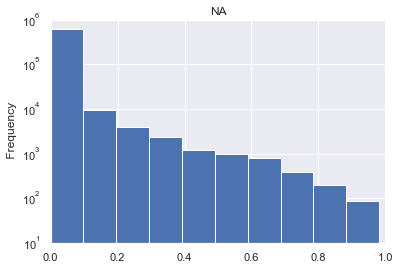

return_ones


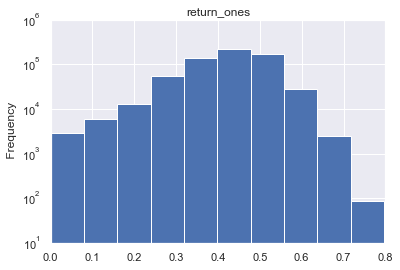

return_zeros


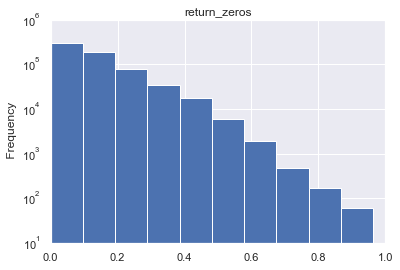

return_minusones


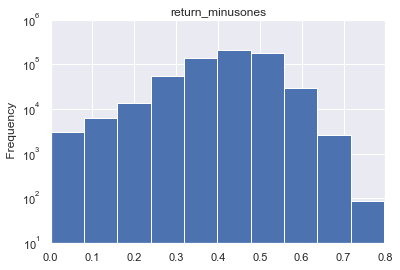

return_sum


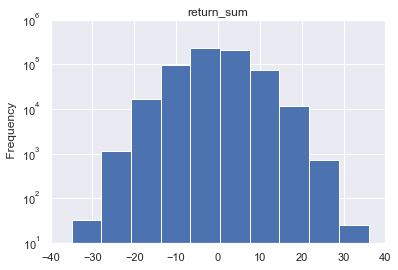

return_abssum


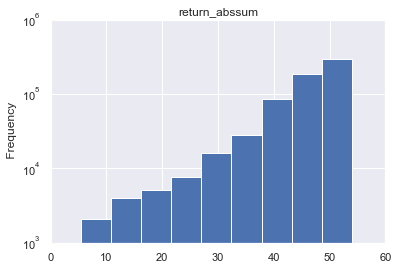

volmean


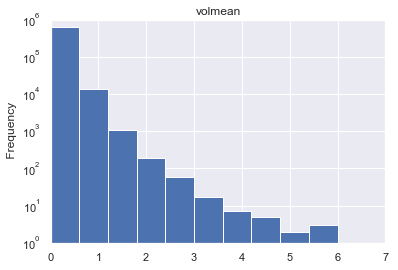

volstd


C:\Anaconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Anaconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


ValueError: max must be larger than min in range parameter.

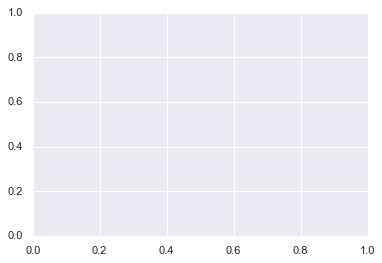

In [47]:
tmp = fdf2.loc[:, "NA":]
for i in tmp.columns:
    print(i)
    plt.hist(fdf2[i])
    plt.title(i)
    plt.ylabel(" Frequency")
    plt.yscale('log', nonposy='clip')
    plt.show()



In [ ]:
df= pd.concat([fdf2, output["TARGET"]], axis=1)
valid = df[df.date>=1563]
training = df[df.date<1563]
X = training.iloc[:,1:-1]
y = training.iloc[:,-1]

X_valid = valid.iloc[:,1:-1]
y_true = valid.iloc[:,-1]
logy = np.log(y)

In [ ]:
%%time
Lm = []
Lt= []
Ld = []
r = range(80, 170, 30)
for i in r:    
    xbr= xgb.XGBRegressor(max_depth=3, learning_rate=0.1, n_estimators=i,  subsample=1,  
                       random_state=42, n_jobs=-1)
    xbr.fit(X, logy)

    logy_pred = xbr.predict(X_valid)
    y_pred = np.exp(logy_pred )
    m= MAPE(y_true, y_pred)
    logyt = xbr.predict(X)
    yt = np.exp(logyt)
    t= MAPE(y, yt)                
    print("mape valid:    "+ str(i), m)
    print("mape training: "+ str(i), t)
    print("delta", m-t)
    print("--------------")              
    
    Lm.append(m)
    Lt.append(t)
    Ld.append(m-t)

In [ ]:
importances = xbr.feature_importances_
feature_importances = pd.DataFrame(importances, index = X.columns, 
                                   columns=['importance']).sort_values('importance', ascending=False)
plt.bar(feature_importances.index, feature_importances["importance"])
plt.show()

feature_importances.head(60)

In [ ]:

post = X_valid.copy()
post["y_true"] = y_true.copy()
post["y_pred"] = y_pred.copy()
post["residus"] = MAPE_residus(post["y_true"], post["y_pred"])


#permodel.sort_values(by="MAPE", ascending=False)[permodel.MAPE > 30]


In [ ]:
m  == MAPE(post["y_true"], post["y_pred"])

In [ ]:
post[post.product_id==211].sort_values(by="residus", ascending=False).head()

In [ ]:
Lmp = []
Lna = []
Lnat = []
r = range(1, len(post.product_id.unique()) +1)
for i in r:
    mape_ = MAPE(post[post.product_id==i].y_true, post[post.product_id==i].y_pred)
    Lmp.append(mape_)
    Lna.append(post[post.product_id==i].NA.mean())
    Lnat.append(test2[test2.product_id==i].NA.mean())

In [ ]:
print(len(r), len(Lmp), len(Lna))

In [ ]:
d={'product_id':r, 'MAPE':Lmp, "NA":Lna,"NA test": Lnat}
perproduct = pd.DataFrame(data=d)

In [ ]:
perproduct.sort_values(by="MAPE", ascending=False)[perproduct.MAPE>30]

In [ ]:
perproduct.sort_values(by="MAPE", ascending=False)[perproduct.NA>0.1]

In [ ]:
perproduct.sort_values(by="MAPE", ascending=False)[perproduct["NA test"]>0.1]

In [ ]:
plt.plot(r, Lmp, label = "MAPE")
plt.legend(loc='upper right')
plt.title("MAPE per product")
plt.show()

plt.plot(r, Lna, label = "NA")
plt.legend(loc='upper right')
plt.title("NA per product")
plt.show()

ax = plt.subplot()
ax.set_xscale("log", nonposx='clip')
#ax.set_yscale("log", nonposy='clip')
plt.plot( 'NA', 'MAPE', data=perproduct, linestyle='', marker='o', markersize=2)
#ax.set_ylim(ymin=0.1)
ax.set_title('MAPE vs NA per product')
plt.show()

ax = plt.subplot()
ax.set_xscale("log", nonposx='clip')
#ax.set_yscale("log", nonposy='clip')
plt.plot( 'NA', 'MAPE', data=perproduct, linestyle='', marker='o', markersize=2)
ax.set_ylim(ymax=40)
ax.set_title('MAPE vs NA per product. Cliped for MAPE>40')
plt.show()

ax = plt.subplot()
#ax.set_xscale("log", nonposx='clip')
#ax.set_yscale("log", nonposy='clip')
plt.plot( 'NA', 'NA test', data=perproduct, linestyle='', marker='o', markersize=2)
#ax.set_ylim(ymax=40)
ax.set_title('NA test vs NA per product. ')
plt.show()

In [ ]:
i = 211
print("MAPE product_id=" +str(i), MAPE(post[post.product_id==i].y_true, post[post.product_id==i].y_pred))
print("NA mean product_id=" +str(i), post[post.product_id==i].NA.mean())

i = 31
print("MAPE product_id=" +str(i), MAPE(post[post.product_id==i].y_true, post[post.product_id==i].y_pred))
print("NA mean product_id=" +str(i), post[post.product_id==i].NA.mean())
      

#### investigating depth when step 2 features (volmean, volstd, ...) are added

In [ ]:
%%time
Lm = []
Lt= []
Ld = []
r = range(3, 7)
for i in r:    
    xbr= xgb.XGBRegressor(max_depth=i, learning_rate=0.1, n_estimators=140,  subsample=1,  
                       random_state=42, n_jobs=-1)
    xbr.fit(X, logy)

    logy_pred = xbr.predict(X_valid)
    y_pred = np.exp(logy_pred )
    m= MAPE(y_true, y_pred)
    logyt = xbr.predict(X)
    yt = np.exp(logyt)
    t= MAPE(y, yt)                
    print("mape valid:    "+ str(i), m)
    print("mape training: "+ str(i), t)
    print("delta", m-t)
    print("--------------")              
    
    Lm.append(m)
    Lt.append(t)
    Ld.append(m-t)

In [ ]:
plt.plot(r, Lt, label = "train")
plt.plot(r, Lm, label = "valid")
plt.legend(loc='upper right')
plt.show()

In [ ]:
test2[test2.product_id==211].NA.mean()

#### post proces ypred: when NA too big, replace per 0
meme en ce cantonant à 211 c'est marginale
en remplacant par la moyenne c'est pire

In [ ]:
post.sort_values(by="residus", ascending=True)[post.NA>0.7].residus.mean()

In [ ]:
post["y_pred2"] = post.y_pred.copy()

In [ ]:
post.y_pred2[post.NA>0.7] =0

In [ ]:
print(" MAPE without rewrite", MAPE(post.y_true, post.y_pred))
print(" MAPE with rewrite", MAPE(post.y_true, post.y_pred2))

In [ ]:
perproduct.sort_values(by="MAPE", ascending=False)[perproduct.NA>0.4]

In [ ]:
post[post.NA>0.8][post.product_id==211].loc[:, "NA":].head()

In [ ]:
t =0.7
y_pred211mean = post.y_pred[post.NA>t][post.product_id==211].mean()

post["y_pred3"] = post.y_pred.copy()
post["y_pred4"] = post.y_pred.copy()

for i in post.y_pred3[post.NA>t][post.product_id==211].index:
    post.loc[i, "y_pred3"]=0
    post.loc[i, "y_pred4"]=y_pred211mean
print(" MAPE without rewrite", MAPE(post.y_true, post.y_pred))
print(" MAPE with rewrite 1", MAPE(post.y_true, post.y_pred2))
print(" MAPE with rewrite 2", MAPE(post.y_true, post.y_pred3))
i = 211
print("without rewrite MAPE product_id=" +str(i), 
      MAPE(post[post.product_id==i].y_true, post[post.product_id==i].y_pred))
print("rewrite 1 MAPE product_id=" +str(i), 
      MAPE(post[post.product_id==i].y_true, post[post.product_id==i].y_pred2))
print("rewrite 2 MAPE product_id=" +str(i), 
      MAPE(post[post.product_id==i].y_true, post[post.product_id==i].y_pred3))
print("rewrite 3 MAPE product_id=" +str(i), 
      MAPE(post[post.product_id==i].y_true, post[post.product_id==i].y_pred4))

In [ ]:
post[post.NA>t][post.product_id==211].head()

In [ ]:
for t in [0.5, 0.6, 0.7, 0.9, 0.95]:
    post["y_pred3"] = post.y_pred.copy()
    for i in post.y_pred3[post.NA>t][post.product_id==211].index:
        post.loc[i, "y_pred3"]=0

    i = 211

    print("rewrite 2 MAPE product_id=" +str(i), t, 
          MAPE(post[post.product_id==i].y_true, post[post.product_id==i].y_pred3))
    
print("without rewrite MAPE product_id=" +str(i), 
      MAPE(post[post.product_id==i].y_true, post[post.product_id==i].y_pred))

### training without 211


reference
mape valid:    140 24.12963942019092
mape training: 140 24.36233000079195
delta -0.2326905806010302

result: le training s'ameliore (evidement), mais valid se degrade legerement
mape valid:    140 24.14341279902005
mape training: 140 23.872494337420903
delta 0.27091846159914823

In [ ]:
df= pd.concat([fdf2, output["TARGET"]], axis=1)
valid = df[df.date>=1563]
training = df[df.date<1563][df.product_id!=211]
X = training.iloc[:,1:-1]
y = training.iloc[:,-1]

X_valid = valid.iloc[:,1:-1]
y_true = valid.iloc[:,-1]
logy = np.log(y)

In [ ]:
%%time
Lm = []
Lt= []
Ld = []
r = range(80, 170, 30)
for i in r:    
    xbr= xgb.XGBRegressor(max_depth=3, learning_rate=0.1, n_estimators=i,  subsample=1,  
                       random_state=42, n_jobs=-1)
    xbr.fit(X, logy)

    logy_pred = xbr.predict(X_valid)
    y_pred = np.exp(logy_pred )
    m= MAPE(y_true, y_pred)
    logyt = xbr.predict(X)
    yt = np.exp(logyt)
    t= MAPE(y, yt)                
    print("mape valid:    "+ str(i), m)
    print("mape training: "+ str(i), t)
    print("delta", m-t)
    print("--------------")              
    
    Lm.append(m)
    Lt.append(t)
    Ld.append(m-t)

### droping less important features

In [ ]:
fdf2b = fdf2.copy()

In [ ]:
feature_importances[feature_importances.importance<0.01].index

In [ ]:
fdf2b.drop(feature_importances[feature_importances.importance<0.01].index, axis=1, inplace=True)

In [ ]:
df= pd.concat([fdf2b, output["TARGET"]], axis=1)
valid = df[df.date>=1563]
training = df[df.date<1563]
X = training.iloc[:,1:-1]
y = training.iloc[:,-1]

X_valid = valid.iloc[:,1:-1]
y_true = valid.iloc[:,-1]
logy = np.log(y)

In [ ]:
X.columns

In [ ]:
%%time
Lm = []
Lt= []
Ld = []
r = range(80, 170, 30)
for i in r:    
    xbr= xgb.XGBRegressor(max_depth=3, learning_rate=0.1, n_estimators=i,  subsample=1,  
                       random_state=42, n_jobs=-1)
    xbr.fit(X, logy)

    logy_pred = xbr.predict(X_valid)
    y_pred = np.exp(logy_pred )
    m= MAPE(y_true, y_pred)
    logyt = xbr.predict(X)
    yt = np.exp(logyt)
    t= MAPE(y, yt)                
    print("mape valid:    "+ str(i), m)
    print("mape training: "+ str(i), t)
    print("delta", m-t)
    print("--------------")              
    
    Lm.append(m)
    Lt.append(t)
    Ld.append(m-t)

In [ ]:
importances = xbr.feature_importances_
feature_importances = pd.DataFrame(importances, index = X.columns, 
                                   columns=['importance']).sort_values('importance', ascending=False)
plt.bar(feature_importances.index, feature_importances["importance"])
plt.show()

feature_importances.head(60)

In [ ]:
temp = fdf2.iloc[:, 2:].columns
temp
fdf2.groupby(['product_id'])[temp].mean().head()

### trying a separate model per product

ref 
mape valid:    110 24.204416648914243
mape training: 110 24.499145575072742
delta -0.29472892615849844

In [ ]:
training.product_id.unique()
#training[training.product_id==1]

In [ ]:
df= pd.concat([fdf2, output["TARGET"]], axis=1)
valid = df[df.date>=1563]
training = df[df.date<1563]


In [ ]:
df.columns

In [ ]:
%%time
Lm = []
Lt= []
Ld = []

for i in range(1, 319):
    X = training[training.product_id==i].iloc[:,1:-1]
    y = training[training.product_id==i].iloc[:,-1]

    X_valid = valid[valid.product_id==i].iloc[:,1:-1]
    y_true = valid[valid.product_id==i].iloc[:,-1]
    logy = np.log(y)
    xbr= xgb.XGBRegressor(max_depth=3, learning_rate=0.1, n_estimators=50,  subsample=1,  #110
                       random_state=42, n_jobs=-1)
    xbr.fit(X, logy)

    logy_pred = xbr.predict(X_valid)
    y_pred = np.exp(logy_pred )
    m= MAPE(y_true, y_pred)
    logyt = xbr.predict(X)
    yt = np.exp(logyt)
    t= MAPE(y, yt)                
    print("mape valid for product_id:    "+ str(i), m)
    print("mape training for product_id: "+ str(i), t)
    print("delta", m-t)
    print("--------------") 
    
    if (i==211):
        X_valid211 = X_valid.copy()
        y_pred211 = y_pred.copy()
        y_true211 = y_true.copy()
        print("saving product_id")
    
    Lm.append(m)
    Lt.append(t)
    Ld.append(m-t)

In [ ]:
r = range(1, 319)
plt.plot(r, Lt, label = "train")
plt.plot(r, Lm, label = "valid")
plt.legend(loc='upper right')

In [ ]:
len(df211.index)

In [ ]:
d={'product_id':r, 'MAPE':Lm}
permodel = pd.DataFrame(data=d)

In [ ]:
permodel.head()

In [ ]:
permodel.sort_values(by="MAPE", ascending=False)[permodel.MAPE > 30]

In [ ]:
r= range(1, len(permodel)+1)
plt.plot(r, permodel.sort_values(by="MAPE", ascending=False).MAPE, label = "MAPE")

plt.legend(loc='upper right')
plt.title("MAPE per product")
plt.show()

s = permodel.sort_values(by="MAPE", ascending=False)[permodel.MAPE < 30].MAPE
r= range(1, len(s)+1)
plt.plot(r,s , label = "MAPE")

plt.legend(loc='upper right')
plt.title("MAPE per product")
plt.show()

In [ ]:
product10 = list(permodel.sort_values(by="MAPE", ascending=False).head(10).product_id)
df[df.product_id.isin(product10)].head()

In [ ]:
df[df.product_id==211].loc[:, :'NA'].head(16)

In [ ]:
df211= df[df.product_id==211]

In [ ]:
df211["NA"].mean()

In [ ]:
plt.plot( 'TARGET', 'NA', data=df211, linestyle='', marker='o', markersize=2)
#plt.yscale('log', nonposy='clip')
#ax.set_xlim(0,)
#ax.set_ylim(-0.1,)
plt.title("NA vs y product 211")
plt.show()

plt.plot( 'TARGET', 'NA', data=df[df.NA>0.2], linestyle='', marker='o', markersize=2)
#plt.yscale('log', nonposy='clip')
#ax.set_xlim(0,)
#ax.set_ylim(-0.1,)
plt.title("NA vs y for NA>0.2")
plt.show()


ax = plt.subplot()
ax.set_xscale("log", nonposx='clip')
#ax.set_yscale("log", nonposy='clip')
plt.plot( 'TARGET', 'NA', data=df211, linestyle='', marker='o', markersize=2, alpha=0.6)
#ax.set_ylim(ymin=0.1)
ax.set_title('NA vs y product 211')
plt.show()

In [ ]:
plt.plot( 'TARGET', 'NA', data=df[df.NA>0.2], linestyle='', marker='o', markersize=2)
#plt.yscale('log', nonposy='clip')
#ax.set_xlim(0,)
#ax.set_ylim(-0.1,)
plt.title("NA vs y for NA>0.2")
plt.show()


ax = plt.subplot()
ax.set_xscale("log", nonposx='clip')
#ax.set_yscale("log", nonposy='clip')
plt.plot( 'TARGET', 'NA', data=df[df.NA>0.2], linestyle='', marker='o', markersize=2, alpha=0.6)
#ax.set_ylim(ymin=0.1)
ax.set_title('NA vs y for NA>0.2 ')
plt.show()

In [ ]:
valid211 = X_valid211.copy()
valid211['y_pred']= y_pred211.copy()
valid211['y_true']= y_true211.copy()
valid211['residus'] = MAPE_residus(y_true211, y_pred211)

In [ ]:

def plot_product(X_valid211, y_pred211, y_true211, rmax=None):
    valid211 = X_valid211.copy()
    valid211['y_pred']= y_pred211.copy()
    valid211['y_true']= y_true211.copy()
    valid211['residus'] = MAPE_residus(y_true211, y_pred211)
    ax = plt.subplot()
    #ax.set_xscale("log", nonposx='clip')
    #ax.set_yscale("log", nonposy='clip')
    plt.plot( 'NA', 'residus', data=valid211, linestyle='', marker='o', markersize=2)
    ax.set_ylim(ymax=rmax)
    plt.title("residus vs NA for product 211 - one outlier out of scale")
    plt.show()
    
plot_product(X_valid211, y_pred211, y_true211, rmax=13)

Une partie desresidus semblemnt s'envoler pour NA> 0.3

### Features engineering: adding the means by products
product_id: 1..318

In [ ]:
r1 = fdf2.loc[fdf2.product_id==31, "volatility 09:30:00":"volatility 13:55:00"].shape[0]
c1 = fdf2.loc[fdf2.product_id==31, "volatility 09:30:00":"volatility 13:55:00"].shape[1]

np.nanmean(fdf2.loc[fdf2.product_id==31, "volatility 09:30:00":"volatility 13:55:00"].values.reshape((r1*c1, 1)))


In [ ]:
%%time

def build_features_3(fdf2):
    col = fdf2.columns[2:]
    fdf3= fdf2.copy()
    for p in range(1, 319):
        v = fdf2.loc[fdf2.product_id==p, "volatility 09:30:00":"volatility 13:55:00"]
        r1 = v.shape[0]
        c1 = v.shape[1]
        fdf3.loc[fdf3.product_id==p, "product_mean"] = np.nanmean(fdf2.loc[fdf2.product_id==p, "volatility 09:30:00":"volatility 13:55:00"].values.reshape((r1*c1, 1)))
        for i in col:
            #col = "return_sum"
            temp = fdf2.loc[fdf2.product_id==p, i].mean()
            #print(i, temp)
            fdf3.loc[fdf3.product_id==p, i] = fdf3.loc[fdf3.product_id==p, i] - temp
    return fdf3

In [ ]:
%%time
fdf3 = build_features_3(fdf2)

In [ ]:
fdf3[fdf3.product_id==4].head()


In [ ]:
fdf2[fdf2.product_id==4].head()

# as is does not work
product mean has high importance but except this, performance are worst (and without it awfull)

avec tout
mape valid:    140 24.2883711902457
mape training: 140 24.52647198244592
delta -0.23810079220021763

importance
product_mean 	0.208163
volmean 	0.134694
return_zeros 	0.080612
vol75% 	0.048980
volatility 13:55:00 	0.043878
NA 	0.034694
volatility 13:50:00 	0.033673

sans product_mean
mape valid:    140 26.030174610130068
mape training: 140 26.279038534587595
delta -0.24886392445752747


In [ ]:
df= pd.concat([fdf3, output["TARGET"]], axis=1)
valid = df[df.date>=1563]
training = df[df.date<1563]
X = training.iloc[:,2:-1]
y = training.iloc[:,-1]

X_valid = valid.iloc[:,2:-1]
y_true = valid.iloc[:,-1]
logy = np.log(y)

In [ ]:
%%time
Lm = []
Lt= []
Ld = []
r = range(80, 170, 30)
for i in r:    
    xbr= xgb.XGBRegressor(max_depth=3, learning_rate=0.1, n_estimators=i,  subsample=1,  
                       random_state=42, n_jobs=-1)
    xbr.fit(X, logy)

    logy_pred = xbr.predict(X_valid)
    y_pred = np.exp(logy_pred )
    m= MAPE(y_true, y_pred)
    logyt = xbr.predict(X)
    yt = np.exp(logyt)
    t= MAPE(y, yt)                
    print("mape valid:    "+ str(i), m)
    print("mape training: "+ str(i), t)
    print("delta", m-t)
    print("--------------")              
    
    Lm.append(m)
    Lt.append(t)
    Ld.append(m-t)

In [ ]:
importances = xbr.feature_importances_
feature_importances = pd.DataFrame(importances, index = X.columns, 
                                   columns=['importance']).sort_values('importance', ascending=False)
plt.bar(feature_importances.index, feature_importances["importance"])
plt.show()

feature_importances

#### trying again without substracting mean to each features, just adding product_mean as a start

reference
mape valid:    140 24.12963942019092
mape training: 140 24.36233000079195
delta -0.2326905806010302

avec product_mean (sans product id)
mape valid:    140 24.04295602135195
mape training: 140 24.257907302708894
delta -0.2149512813569423

et product_std en plus: ne change pas grand chose
mape valid:    140 24.04486471918276
mape training: 140 24.27193480127085
delta -0.22707008208809043


In [ ]:
%%time

def build_features_4(fdf2):
    col = fdf2.columns[2:]
    fdf4= fdf2.copy()
    for p in range(1, 319):
        v = fdf2.loc[fdf2.product_id==p, "volatility 09:30:00":"volatility 13:55:00"]
        r1 = v.shape[0]
        c1 = v.shape[1]
        fdf4.loc[fdf3.product_id==p, "product_mean"] = np.nanmean(fdf2.loc[fdf2.product_id==p, "volatility 09:30:00":"volatility 13:55:00"].values.reshape((r1*c1, 1)))
        fdf4.loc[fdf3.product_id==p, "product_std"] = np.nanstd(fdf2.loc[fdf2.product_id==p, "volatility 09:30:00":"volatility 13:55:00"].values.reshape((r1*c1, 1)))
    return fdf4

In [ ]:
%%time
fdf4 = build_features_4(fdf2)

In [ ]:
%%time
test4 = build_features_4(test2)

In [ ]:
fdf4.head()

In [ ]:
df= pd.concat([fdf4, output["TARGET"]], axis=1)
valid = df[df.date>=1563]
training = df[df.date<1563]
X = training.iloc[:,2:-1]
y = training.iloc[:,-1]

X_valid = valid.iloc[:,2:-1]
y_true = valid.iloc[:,-1]
logy = np.log(y)

In [ ]:
X.columns

In [ ]:
%%time

Lm = []
Lt= []
Ld = []
r = range(80, 170, 30)
for i in r:    
    xbr= xgb.XGBRegressor(max_depth=3, learning_rate=0.1, n_estimators=i,  subsample=1,  
                       random_state=42, n_jobs=-1)
    xbr.fit(X, logy)

    logy_pred = xbr.predict(X_valid)
    y_pred = np.exp(logy_pred )
    m= MAPE(y_true, y_pred)
    logyt = xbr.predict(X)
    yt = np.exp(logyt)
    t= MAPE(y, yt)                
    print("mape valid:    "+ str(i), m)
    print("mape training: "+ str(i), t)
    print("delta", m-t)
    print("--------------")              
    
    Lm.append(m)
    Lt.append(t)
    Ld.append(m-t)

In [ ]:
importances = xbr.feature_importances_
feature_importances = pd.DataFrame(importances, index = X.columns, 
                                   columns=['importance']).sort_values('importance', ascending=False)
plt.bar(feature_importances.index, feature_importances["importance"])
plt.show()

feature_importances

In [ ]:
%%time
Lm = []
Lt= []
Ld = []
r = range(3, 7)
for i in r:    
    xbr= xgb.XGBRegressor(max_depth=i, learning_rate=0.1, n_estimators=140,  subsample=1,  
                       random_state=42, n_jobs=-1)
    xbr.fit(X, logy)

    logy_pred = xbr.predict(X_valid)
    y_pred = np.exp(logy_pred )
    m= MAPE(y_true, y_pred)
    logyt = xbr.predict(X)
    yt = np.exp(logyt)
    t= MAPE(y, yt)                
    print("mape valid:    "+ str(i), m)
    print("mape training: "+ str(i), t)
    print("delta", m-t)
    print("--------------")              
    
    Lm.append(m)
    Lt.append(t)
    Ld.append(m-t)

In [ ]:
plt.plot(r, Lt, label = "train")
plt.plot(r, Lm, label = "valid")
plt.legend(loc='upper right')
plt.show()

In [ ]:
importances = xbr.feature_importances_
feature_importances = pd.DataFrame(importances, index = X.columns, 
                                   columns=['importance']).sort_values('importance', ascending=False)
plt.bar(feature_importances.index, feature_importances["importance"])
plt.show()

feature_importances

#### let's push with depth = 4 (instead of the default 3)

ref for depth 3 for 140 estimators
mape valid:    3 24.12963942019092
mape training: 3 24.36233000079195
delta -0.2326905806010302

In [ ]:
%%time
Lm = []
Lt= []
Ld = []
r = range(100, 210, 10)
for i in r:    
    xbr= xgb.XGBRegressor(max_depth=4, learning_rate=0.1, n_estimators=i,  subsample=1,  
                       random_state=42, n_jobs=-1)
    xbr.fit(X, logy)

    logy_pred = xbr.predict(X_valid)
    y_pred = np.exp(logy_pred )
    m= MAPE(y_true, y_pred)
    logyt = xbr.predict(X)
    yt = np.exp(logyt)
    t= MAPE(y, yt)                
    print("mape valid:    "+ str(i), m)
    print("mape training: "+ str(i), t)
    print("delta", m-t)
    print("--------------")              
    
    Lm.append(m)
    Lt.append(t)
    Ld.append(m-t)

In [ ]:
plt.plot(r, Lt, label = "train")
plt.plot(r, Lm, label = "valid")
plt.legend(loc='upper right')
plt.show()

trying regulatisation

In [ ]:
%%time

for l in [2, 3, 4, 5]:
    Lm = []
    Lt= []
    Ld = []
    r = range(130, 200, 10)
    print("--------------------------------")
    print("lambda", l)
    for i in r:    
        xbr= xgb.XGBRegressor(max_depth=4, learning_rate=0.1, n_estimators=i,  subsample=1,  
                           random_state=42, n_jobs=-1, reg_lambda=l)
        xbr.fit(X, logy)

        logy_pred = xbr.predict(X_valid)
        y_pred = np.exp(logy_pred )
        m= MAPE(y_true, y_pred)
        logyt = xbr.predict(X)
        yt = np.exp(logyt)
        t= MAPE(y, yt)                
        print("mape valid:    "+ str(i), m)
        print("mape training: "+ str(i), t)
        print("delta", m-t)
        print("--------------")              

        Lm.append(m)
        Lt.append(t)
        Ld.append(m-t)

    plt.plot(r, Lt, label = "train")
    plt.plot(r, Lm, label = "valid")
    plt.legend(loc='upper right')
    plt.title("train/valid for estimators" +str(i) + " and lambda" +  str(l))
    plt.show()

Trying to submit

In [ ]:
X.columns

In [ ]:
test4.head()

In [ ]:
X = fdf4.iloc[:,2:]
y = output["TARGET"]

logy = np.log(y)
X_test = test4.iloc[:,3:]

In [ ]:
X_test.columns

In [ ]:
X.columns == X_test.columns

In [ ]:
xbr= xgb.XGBRegressor(max_depth=4, learning_rate=0.1, n_estimators=170,  subsample=1,  
                           random_state=42, n_jobs=-1, reg_lambda=4)

xbr.fit(X, logy)
logy_pred = xbr.predict(X_test)
y_pred = np.exp(logy_pred )





In [ ]:
logyt = xbr.predict(X)
yt = np.exp(logyt)

print(MAPE(y, yt))

 

In [ ]:
# score challenge 24.37
#mape valid:    170 23.971816721617984
#mape training: 170 23.99550792956179

d = {'TARGET':y_pred}
result = pd.DataFrame(data=d)
result.to_csv('C:\\Users\\i053131\\Desktop\\Epilepsie\\CFM\\data\\processed\\xgb_feature_4_d4_e170_l4.csv', 
              sep = ";",index_label="ID")

# Variability of return

In [ ]:
def get_return_inflexions(s, viz=False): #s is a serie
    #an inflexion point is when
    #return = 1 after a series of -1 or 0
    #return = -1 after a series of 1 or 0
    inflexlist = []
    tendance =0
    for i in range(0, len(s)):
        if (np.isnan(s[i]) or s[i] ==0): #0 does not change tendance
            continue
        if (tendance != s[i]):
            inflexlist.append(i)
            tendance = s[i]
    
    
    ybeat = [s[x] for x in inflexlist] #Get the y-value of all peaks for plotting purposes
    if (viz):
        fig = plt.figure(figsize=(14, 8))
        ax1 = fig.add_subplot(211)
        ax1.set_title("Detected peaks in signal")
        #ax1.set_xlim(0,1500)
        ax1.plot(s, alpha=0.5, color='blue') #Plot semi-transparent HR
        
        ax1.scatter(inflexlist, ybeat, color='red') #Plot detected peaks
        fig.show()
    return inflexlist

In [ ]:
get_return_inflexions(return_.loc[1, :], viz=True)

Heart Rate Variability” (HRV) measures:
- IBI (inter-beat interval), the mean distance of intervals between heartbeat
- SDNN, the standard deviation of intervals between heartbeats (usually computed on the average of 5 minutes on 24 hours)
- SDSD, the standard deviation of successive differences between adjacent R-R intervals
- RMSSD, the root mean square of successive differences between adjacent R-R intervals:
- pNN50, the number of pairs of successive differences  that differ by more than 50 ms / total number of pairs. As the sampling rate is 50hz, 20 ms differences is on "tick" and we can have pNN60 but not pNN50
- median absolute deviation of RR intervals (MAD)

In [ ]:
def BPM(peak):
    return len(peak)*2